<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Advance_Regression/02-02-01-regularized-glm-regression-r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 1. Regularized Generalized Linear Model  (Gaussian)

Regularized regression methods are vital for managing high-dimensional datasets or multicollinearity. Techniques like Ridge, Lasso, and Elastic Net add a penalty term to the least squares objective, stabilizing and improving model performance, especially when traditional linear regression risks overfitting. In this tutorial, we will fit Regularized Generalized Linear Models (GLMs) for continuous (Gaussian) data in R. We will start by examining regularization techniques and build models for Ridge, Lasso, and Elastic Net to understand their mathematical foundations. We will then explore the {glmnet} package, which streamlines fitting and cross-validating these models and optimizes the regularization parameter $\lambda$. We will evaluate each model’s performance using cross-validation and discuss the most suitable contexts for each technique. By the end of this tutorial, you will understand how to implement and interpret regularized GLM models for continuous data in R from both foundational and practical perspectives.



## Overview

A regularized Generalized Linear Model (GLM) with a Gaussian distribution is essentially a regularized linear regression model. When the response variable ( Y ) follows a Gaussian (normal) distribution, the GLM simplifies to ordinary least squares (OLS) regression. Adding regularization modifies the objective function to penalize the size of the coefficients, aiming to prevent overfitting and improve model interpretability and generalizability.

***1. Standard Linear Regression (GLM with Gaussian Distribution)***

In a standard linear regression (GLM with a Gaussian distribution):

-   **Random Component**: The response variable $Y$ follows a normal distribution with mean $\mu$ and variance $\sigma^2$. $$   Y \sim \mathcal{N}(\mu, \sigma^2) $$

-   **Systematic Component**: We assume a linear relationship between predictors and the mean of the response:

    $$  \mu = X \ $$

    where $X$ is the matrix of predictors and $\beta$) is the vector of coefficients.

-   **Identity Link Function**: For Gaussian distributions, the link function $g(\mu) = \mu$, meaning $\mathbb{E}[Y] = X \beta$.

The objective function for linear regression is derived by maximizing the likelihood, which is equivalent to minimizing the **sum of squared errors (SSE)**:

$$ \mathcal{L}(\beta) = \sum_{i=1}^n (y_i - X_i \beta)^2 $$

***2. Regularized Linear Regression (Regularized Gaussian GLM)***

In regularized regression, we add a penalty term to the objective function to control the size of the coefficients ( \beta ). The regularized objective function becomes:

$$ \mathcal{L}_{\text{regularized}}(\beta) = \sum_{i=1}^n (y_i - X_i \beta)^2 + \lambda P $$

where:

\- $\lambda \geq 0$ is the regularization parameter, controlling the amount of penalty.

$P(\beta)$ is the penalty function. Common choices include:

-   **L2 norm (Ridge Regression)**:

$$ P(\beta) = \|\beta\|_2^2 =\sum_{j=1}^p \beta_j^2 $$

-   **L1 norm (Lasso Regression**

$$ P(\beta) = \|\beta\|_1 = \sum_{j=1}^p |\beta_j| $$

-   **Elastic Net**:

$$ P(\beta) = \alpha\|\beta\|_1 + (1 - \alpha) \|\beta\|_2^2 $$

which combines L1 and L2 penalties.

***Ridge (L2) Regularization:***

For Ridge regression, the objective function is: $$ \mathcal{L}_{\text{ridge}}(\beta) = \sum_{i=1}^n (y_i - X_i \beta)^2 + \lambda \sum_{j=1}^p \beta_j^2 $$

The L2 penalty shrinks the coefficients toward zero but does not set them exactly to zero, making it useful for models with many correlated predictors.

***Lasso (L1) Regularization***:

For Lasso regression, the objective function is: $$ \mathcal{L}_{\text{lasso}}(\beta) = \sum_{i=1}^n (y_i - X_i \beta)^2 + \lambda \sum_{j=1}^p |\beta_j| $$

The L1 penalty encourages sparsity, meaning it tends to set some coefficients exactly to zero, which is useful for feature selection.

***Elastic Net Regularization***:

For Elastic Net, the objective function is a combination of both L1 and L2 penalties:

$$ \mathcal{L}_{\text{elastic net}}(\beta) = \sum_{i=1}^n (y_i - X_i \beta)^2 + \lambda \left( \alpha \sum_{j=1}^p |\beta_j| + (1 - \alpha) \sum_{j=1}^p \beta_j^2 \right) $$ Elastic Net allows you to balance between Lasso and regularization, providing both feature selection and coefficient shrinkage.

***Optimization***

The coefficients $\beta$ are estimated by minimizing the regularized objective function with respect to $\beta$. Depending on the penalty, different optimization techniques are used:

-   **Ridge**: Closed-form solutions (matrix inversion) or gradient descent.
-   **Lasso and Elastic Net**: Coordinate descent, which optimizes one parameter at a time, is typically used.

### Install rpy2

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.4.2
Uninstalling rpy2-3.4.2:
  Successfully uninstalled rpy2-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp311-cp311-linux_x86_64.whl size=314974 sha256=ad0643382980de554aa79a8aa3fde27b8a27d71a96af9e04d093be08a48f7a6d
  Stored in directory: /root/.cache/pip/wheels/e9/55/d1/47be85a5f3f1e1f4d1e91cb5e3a4dcb40dd72147f184c5a5ef
Successfully built rpy2


### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Regularized GLM Regression Model from Scratch

To perform regularized regression (Ridge, Lasso, and Elastic Net) on synthetic data in R without using any libraries, we need to manually implement each regularization method in the GLM framework. Here’s how to proceed:

### Generate Synthetic Data

Let's create synthetic data with one continuous response variable ( y ) and four predictors ( x_1, x_2, x_3, x_4 ).

In [ ]:
%%R
# Generate Synthetic Data
set.seed(123)
n <- 100
p <- 10
X <- matrix(rnorm(n * p), n, p)
beta <- c(1, -1, 0, 0.5, -0.5, rep(0, p - 5))
y <- X %*% beta + rnorm(n)

### Coordinate Descent Algorithm for Regularized Regression

Next, we implement the coordinate descent algorithm to solve the regularized regression problem. The algorithm iteratively updates each coefficient by minimizing the objective function with respect to that coefficient while keeping the others fixed. The update rule depends on the type of regularization (Ridge, Lasso, or Elastic Net). Here’s the implementation in R:


In [ ]:
%%R
 # Coordinate Descent Algorithm
coordinate_descent <- function(X, y, lambda, alpha, tol = 1e-6, max_iter = 1000) {
  n <- nrow(X)
  p <- ncol(X)
  beta <- rep(0, p)
  X <- scale(X)  # Standardize features
  y <- y - mean(y)  # Center target

  for (iter in 1:max_iter) {
    beta_old <- beta
    for (j in 1:p) {
      r_j <- y - X %*% beta + beta[j] * X[, j]
      z_j <- sum(X[, j]^2)
      rho_j <- sum(X[, j] * r_j)

      # Update beta based on the type of model (Ridge, Lasso, ElasticNet)
      beta[j] <- ifelse(alpha == 1, # Lasso
                        sign(rho_j) * max(abs(rho_j) - lambda, 0) / z_j,
                        ifelse(alpha == 0, # Ridge
                               rho_j / (z_j + lambda),
                               # Elastic Net
                               sign(rho_j) * max(abs(rho_j) - lambda * alpha, 0) / (z_j + lambda * (1 - alpha))))
    }
    if (sum(abs(beta - beta_old)) < tol) break
  }
  return(beta)
}



### Cross-Validation for Hyperparameter Tuning (including alpha)

We can perform cross-validation to select the best hyperparameters (alpha and lambda) for the regularized regression model. This involves splitting the data into k folds, training the model on k-1 folds, and evaluating it on the remaining fold. We repeat this process for different values of alpha and lambda to find the best combination. Here’s how to implement cross-validation in R:### Fit the Models


In [ ]:
%%R
# Cross-Validation for Hyperparameter Tuning (including alpha)
cv_glm <- function(X, y, alpha_seq, lambda_seq, k = 5) {
  n <- nrow(X)
  folds <- sample(1:k, n, replace = TRUE)
  best_mse <- Inf
  best_lambda <- NULL
  best_alpha <- NULL

  for (alpha in alpha_seq) {
    mse_vals <- numeric(length(lambda_seq))

    for (i in seq_along(lambda_seq)) {
      lambda <- lambda_seq[i]
      fold_errors <- numeric(k)

      # Cross-validation for each fold
      for (fold in 1:k) {
        X_train <- X[folds != fold, ]
        y_train <- y[folds != fold]
        X_val <- X[folds == fold, ]
        y_val <- y[folds == fold]

        beta <- coordinate_descent(X_train, y_train, lambda, alpha)
        y_pred <- X_val %*% beta
        fold_errors[fold] <- mean((y_val - y_pred)^2)
      }
      mse_vals[i] <- mean(fold_errors)
    }

    # Find the best lambda for the current alpha
    min_mse <- min(mse_vals)
    if (min_mse < best_mse) {
      best_mse <- min_mse
      best_lambda <- lambda_seq[which.min(mse_vals)]
      best_alpha <- alpha
    }
  }

  return(list(best_alpha = best_alpha, best_lambda = best_lambda))
}

### Train Models for All Alpha Values

Finally, we can train the regularized regression models for all alpha values (0 for Ridge, 0.5 for Elastic Net, and 1 for Lasso) and select the best alpha and lambda based on cross-validation results. We then fit the final model using the best hyperparameters and evaluate its performance. Here’s how to implement this in R:

In [ ]:
%%R
# Standardize X for better regularization performance
X_scaled <- scale(X)

# Train Models for All Alpha Values
alpha_values <- c(0, 0.5, 1)  # Ridge (0), ElasticNet (0.5), Lasso (1)
lambda_seq <- 10^seq(-3, 1, length.out = 50)

# Find the best alpha and lambda
cv_results <- cv_glm(X_scaled, y, alpha_values, lambda_seq, k = 5)

# Best alpha and lambda
best_alpha <- cv_results$best_alpha
best_lambda <- cv_results$best_lambda

# Train the final model using the best alpha and lambda
final_beta <- coordinate_descent(X_scaled, y, best_lambda, best_alpha)
y_pred <- X_scaled %*% final_beta

# Calculate performance metrics
mse <- mean((y - y_pred)^2)
r_squared <- 1 - sum((y - y_pred)^2) / sum((y - mean(y))^2)

cat("\nFinal Model (Best Alpha =", best_alpha, "and Lambda =", best_lambda, "):\n")
cat("MSE:", mse, "\n")
cat("R-squared:", r_squared, "\n")


Final Model (Best Alpha = 1 and Lambda = 1.84207 ):
MSE: 1.025086 
R-squared: 0.7275239 


### Visualize Coefficients

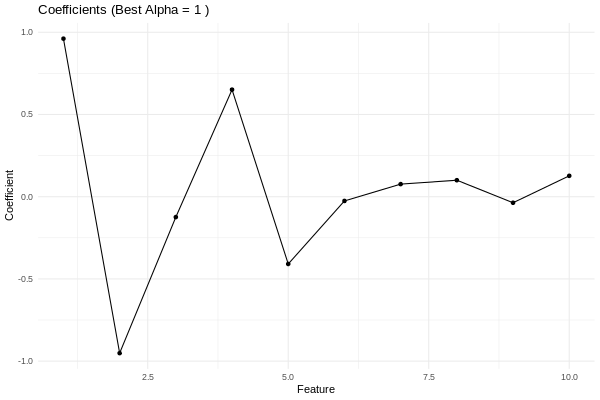

In [ ]:
%%R -w 600 -h 400

library(ggplot2)
# Visualize Coefficients
coef_df <- data.frame(
  Feature = 1:ncol(X),
  Coefficients = final_beta
)

ggplot(coef_df, aes(x = Feature, y = Coefficients)) +
  geom_point() +
  geom_line() +
  labs(title = paste("Coefficients (Best Alpha =", best_alpha, ")"), x = "Feature", y = "Coefficient") +
  theme_minimal()

### Fit Ridge, Lasso, and Elastic Net models

Fit Ridge, Lasso, and Elastic Net models:

In [ ]:
%%R
# Fit Ridge, Lasso, and Elastic Net models
ridge_beta <- coordinate_descent(X_scaled, y, lambda = best_lambda, alpha = 0)
lasso_beta <- coordinate_descent(X_scaled, y, lambda = best_lambda, alpha = 1)
elastic_net_beta <- coordinate_descent(X_scaled, y, lambda = best_lambda, alpha = best_alpha)

# Combine coefficients into a data frame
coef_summary <- data.frame(
  Predictor = paste0("X", 1:10),
  Ridge = round(ridge_beta, 3),
  Lasso = round(lasso_beta , 3),
  Elastic_Net = round(elastic_net_beta, 3)

)

print(coef_summary)

   Predictor  Ridge  Lasso Elastic_Net
1         X1  0.954  0.961       0.961
2         X2 -0.951 -0.951      -0.951
3         X3 -0.140 -0.124      -0.124
4         X4  0.646  0.651       0.651
5         X5 -0.416 -0.409      -0.409
6         X6 -0.042 -0.026      -0.026
7         X7  0.090  0.077       0.077
8         X8  0.117  0.100       0.100
9         X9 -0.053 -0.037      -0.037
10       X10  0.143  0.127       0.127


### Predicted Values for Each Model

In [ ]:
%%R
# Predicted values for each model
y_pred_ridge <- X_scaled %*% ridge_beta
y_pred_lasso <- X_scaled %*% lasso_beta
y_pred_elastic_net <- X_scaled %*% elastic_net_beta

### Evaluate Model Performance

To evaluate the models, calculate the Mean Squared Error (MSE) between the true response and predicted values.

In [ ]:
%%R
calculate_metrics <- function(observed, predicted) {
  # Ensure inputs are numeric vectors
  observed <- as.numeric(observed)
  predicted <- as.numeric(predicted)

  # Compute metrics
  mse <- mean((observed - predicted)^2)
  rmse <- sqrt(mse)
  mae <- mean(abs(observed - predicted))
  medae <- median(abs(observed - predicted))
  r2 <- 1 - sum((observed - predicted)^2) / sum((observed - mean(observed))^2)

  # Return results as a named list
  metrics <- list(
    RMSE = rmse,
    MAE = mae,
    MSE = mse,
    MedAE = medae,
    R2 = r2
  )
  return(metrics)
}

In [ ]:
%%R
# Evaluate Ridge model
calculate_metrics(y, y_pred_ridge)

$RMSE
[1] 1.011627

$MAE
[1] 0.7968189

$MSE
[1] 1.02339

$MedAE
[1] 0.6705467

$R2
[1] 0.7279747



In [ ]:
%%R
# Evaluate Lasso model
calculate_metrics(y, y_pred_lasso)

$RMSE
[1] 1.012465

$MAE
[1] 0.7986907

$MSE
[1] 1.025086

$MedAE
[1] 0.6622258

$R2
[1] 0.7275239



In [ ]:
%%R
# Evaluate Elastic Net model
calculate_metrics(y,y_pred_elastic_net)

$RMSE
[1] 1.012465

$MAE
[1] 0.7986907

$MSE
[1] 1.025086

$MedAE
[1] 0.6622258

$R2
[1] 0.7275239



The output `cv_results` will contain the average MSE across all folds for each model (Ridge, Lasso, Elastic Net). Comparing these values allows us to determine which regularization method performs best with this synthetic data.

## Regularized GLM Regression Model in R

To fit a Regularized Generalized Linear Model (GLM) with a Gaussian distribution (equivalent to linear regression) in R, we will use {glmnet} package.

### Install Rrequired R Packages

In [3]:
%%R
packages <- c('tidyverse',
     'plyr',
		 'ggpmisc',
		 'rstatix',
		 'ggeffects',
		 'patchwork',
		 'Metrics',
		 'ggpmisc',
		 'glmnet'
	  	)


In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(pkg %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

In [4]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:


  method                  from   
  heightDetails.titleGrob ggplot2
  widthDetails.titleGrob  ggplot2



tidyverse      plyr   ggpmisc   rstatix ggeffects patchwork   Metrics   ggpmisc 
     TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE 
   glmnet 
     TRUE 


### Load R Packages

In [5]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])# Check loaded packages


Successfully loaded packages:
 [1] "package:glmnet"    "package:Matrix"    "package:Metrics"  
 [4] "package:patchwork" "package:ggeffects" "package:rstatix"  
 [7] "package:ggpmisc"   "package:ggpp"      "package:plyr"     
[10] "package:lubridate" "package:forcats"   "package:stringr"  
[13] "package:dplyr"     "package:purrr"     "package:readr"    
[16] "package:tidyr"     "package:tibble"    "package:ggplot2"  
[19] "package:tidyverse" "package:tools"     "package:stats"    
[22] "package:graphics"  "package:grDevices" "package:utils"    
[25] "package:datasets"  "package:methods"   "package:base"     


### Data

Our goal is to develop a GLM regression model to predict paddy soil arsenic (`SAs`) concentration using various irrigation water and soil properties. We have available data of 263 paired groundwater and paddy soil samples from arsenic contaminated areas in Tala Upazilla, Satkhira district, Bangladesh. This data was utilized in a publication titled "Factors Affecting Paddy Soil Arsenic Concentration in Bangladesh: Prediction and Uncertainty of Geostatistical Risk Mapping" which can be accessed via the this [URL](https://doi.org/10.1016/j.scitotenv.2011.10.008)

Full data set is available for download from my [Dropbox](https://www.dropbox.com/scl/fo/2rh6r68i9cxmgortvbw8q/h?rlkey=bvntt66n9mcywprmdki08ch3r&dl=0) or from my [Github](https://github.com/zia207/r-colab/tree/main/Data/Regression_analysis) accounts.

We will use `read_csv()` function of **readr** package to import data as a **tidy** data.


In [ ]:
%%R
# load data from Github
mf<-read_csv("https://github.com/zia207/r-colab/raw/main/Data/Regression_analysis/bd_soil_arsenic.csv")

Rows: 263 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Land_type
dbl (28): ID, Longitude, Latitude, WAs, WP, WFe, WEc, WpH, WMg, WNa, WCa, WK...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Data Processing

In [ ]:
%%R
df <- mf |>
  # select variables
  dplyr::select (WAs, WP, WFe,
                WEc, WpH, SAoFe, SpH, SOC,
                Sand, Silt, SP, Elevation,
                Year_Irrigation, Distance_STW,
                Land_type, SAs) |>
   # convert to factor
   dplyr::mutate_at(vars(Land_type), funs(factor))  |>
   # create a variable
   dplyr::mutate (Silt_Sand = Silt+Sand)  |>
   # drop two variables
   dplyr::select(-c(Silt,Sand)) |>
   # relocate or organized variable
   dplyr::relocate(SAs, .after=Silt_Sand) |>
   dplyr::relocate(Land_type, .after=Silt_Sand) |>
   # normalize the all numerical features
   # dplyr::mutate_at(1:13,  funs((.-min(.))/max(.-min(.)))) |>
   glimpse()

Rows: 263
Columns: 15
$ WAs             <dbl> 0.059, 0.059, 0.079, 0.122, 0.072, 0.042, 0.075, 0.064…
$ WP              <dbl> 0.761, 1.194, 1.317, 1.545, 0.966, 1.058, 0.868, 0.890…
$ WFe             <dbl> 3.44, 4.93, 9.70, 8.58, 4.78, 6.95, 7.81, 8.14, 8.99, …
$ WEc             <dbl> 1.03, 1.07, 1.40, 0.83, 1.42, 1.82, 1.71, 1.74, 1.57, …
$ WpH             <dbl> 7.03, 7.06, 6.84, 6.85, 6.95, 6.89, 6.86, 6.98, 6.82, …
$ SAoFe           <dbl> 2500, 2670, 2160, 2500, 2060, 2500, 2520, 2140, 2150, …
$ SpH             <dbl> 7.74, 7.87, 8.03, 8.07, 7.81, 7.77, 7.66, 7.89, 8.00, …
$ SOC             <dbl> 1.66, 1.26, 1.36, 1.61, 1.26, 1.74, 1.71, 1.69, 1.41, …
$ SP              <dbl> 13.79, 15.31, 15.54, 16.28, 14.20, 13.41, 13.26, 14.84…
$ Elevation       <dbl> 3, 5, 4, 3, 5, 2, 2, 3, 3, 3, 2, 5, 6, 6, 5, 5, 4, 6, …
$ Year_Irrigation <dbl> 14, 20, 10, 8, 10, 9, 8, 10, 8, 2, 20, 4, 15, 10, 5, 4…
$ Distance_STW    <dbl> 5, 6, 5, 8, 5, 5, 10, 8, 10, 8, 5, 5, 9, 5, 10, 10, 12…
$ Silt_Sand       

#### Split Data to Training and Test Sets

We will use the `ddply()` function of the **plyr** package to split soil carbon datainto homogeneous subgroups using **stratified random sampling**. This method involves dividing the population into strata and taking random samples from each stratum to ensure that each subgroup is proportionally represented in the sample. The goal is to obtain a representative sample of the population by adequately representing each stratum.

In [ ]:
%%R
seeds = 11076
tr_prop = 0.70
# training data (70% data)
train= ddply(df,.(Land_type),
                 function(., seed) { set.seed(seed); .[sample(1:nrow(.), trunc(nrow(.) * tr_prop)), ] }, seed = 101)
test = ddply(df, .(Land_type),
            function(., seed) { set.seed(seed); .[-sample(1:nrow(.), trunc(nrow(.) * tr_prop)), ] }, seed = 101)

#### Create x and y

You need to create two objects:

-   `y` for storing the outcome variable
-   `x` for holding the predictor variables. This should be created using the function model.matrix() allowing to automatically transform any qualitative variables (if any) into dummy variables, which is important because `glmnet()` can only take numerical, quantitative inputs. After creating the model matrix, we remove the intercept component at index = 1.

 use `model.matrix()` when you get "error in evaluating the argument 'x' in selecting a method for function 'as.matrix'". For some reason glmnet prefers `data.matrix()` to `as.matrix()`

In [ ]:
%%R
# Predictor variables
x.train <- model.matrix(SAs~., train)[,-1]
# Outcome variable
y.train <-train$SAs

### Ridge Regression

#### Cross-validation for the best lambda

Now we can apply `cv.glmnet()` function for cross-validation to choose the best lambda (regularization parameter). For example, suppose we designate $α$=0 for ridge regression and specify `nlambda` as 200. This implies that the model fit will be calculated solely for 200 $λ$ values.

In [ ]:
%%R
# cross validation
ridge.cv <- cv.glmnet(x= x.train,
                       y= y.train,
                       type.measure="mse",
                       nfold = 5,
                       alpha=0,
                       family="gaussian",
                       nlambda=200,
                       standardize = TRUE)

Printing the resulting object gives some basic information on the cross-validation performed:

In [ ]:
%%R
print(ridge.cv)


Call:  cv.glmnet(x = x.train, y = y.train, type.measure = "mse", nfolds = 5,      alpha = 0, family = "gaussian", nlambda = 200, standardize = TRUE) 

Measure: Mean-Squared Error 

    Lambda Index Measure    SE Nonzero
min  1.376   173   28.02 3.055      14
1se  7.988   135   30.99 4.543      14


We can plot `ridge.cv` object to see how each tested lambda value performed:

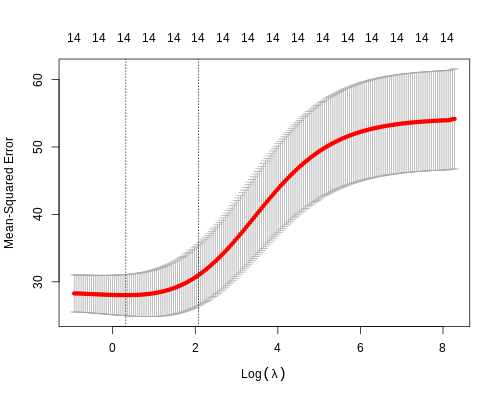

In [ ]:
%%R -w 500 -h 400 -u px
plot(ridge.cv)

On the graph, the x-axis represents the logarithm of $λ$, and the y-axis shows the `mean-squared error (MSE)`. A lower `MSE` indicates a better fit. The graph highlights two specific $λ$ values with dotted vertical lines. The first value, `lambda.min`, resulted in the lowest mean-squared error. The second value, called `lambda.1se`, represents the most considerable $λ$ value that provides cross-validated error within one standard error of the minimum. Generally, `lambda.1se` is more important than `lambda.min` because its goal is to prevent over-fitting. Therefore, we will sacrifice some goodness of fit for greater regularization.

Now, we will extract the`lambda.1se` with lowest `MSE`:

In [ ]:
%%R
# Choose lambda with standard error of the minimum
ridge.cv$lambda.1se

[1] 7.987695


#### Fit ridge regression

Now Fit the final model with the best "lambda":

In [ ]:
%%R
# fit ridge regression
ridge.fit <-  glmnet(x= x.train,
                       y= y.train,
                       alpha=0,
                       lambda = ridge.cv$lambda.1se,
                       family="gaussian",
                       nlambda=200,
                       standardize = TRUE)

Printing the resulting object gives some basic information on `glmnet()` function performed:

In [ ]:
%%R
print(ridge.fit)


Call:  glmnet(x = x.train, y = y.train, family = "gaussian", alpha = 0,      nlambda = 200, lambda = ridge.cv$lambda.1se, standardize = TRUE) 

  Df  %Dev Lambda
1 14 47.43  7.988


The output includes the call that generated the `ridge.fit` object. Additionally, it displays a three-column matrix containing the following columns: `Df` (the number of nonzero coefficients), `%dev` (the percentage of deviance explained), and `Lambda` (the corresponding value of $λ$). You can use the `digits` parameter to specify the number of significant digits in the printed output.

Finally we will extract the coefficients for the selected $λ$ using `coef()` function:

In [ ]:
%%R
coef(ridge.fit)

15 x 1 sparse Matrix of class "dgCMatrix"
                           s0
(Intercept)     13.2099725762
WAs              6.7164555611
WP               0.3804027472
WFe              0.3493429629
WEc              0.3119772753
WpH             -0.1169126885
SAoFe           -0.0005835623
SpH              0.3508412746
SOC              1.6901302632
SP               0.0659128651
Elevation       -0.3067938115
Year_Irrigation  0.3843561522
Distance_STW    -0.0804925909
Silt_Sand       -0.0759818371
Land_typeMHL     1.9065149235


#### Prediction at Test Data

Now, we will test this model on our test dataset by calculating the model-predicted values for the test dataset and then computing the MAE, MSE, RMSE and R-square:

In [ ]:
%%R
# Make predictions on the test data
x.test <- model.matrix(SAs ~., test)[,-1]
y.test <-test$SAs

ridge.SAs<-ridge.fit  |>
  predict(x.test)  |>  as.vector()
ridge.pred<-as.data.frame(cbind("Obs_SAs" = y.test, "Pred_SAs"=ridge.SAs))
glimpse(ridge.pred)

Rows: 80
Columns: 2
$ Obs_SAs  <dbl> 11.30, 17.10, 11.70, 13.60, 19.80, 14.80, 15.10, 17.20, 10.00…
$ Pred_SAs <dbl> 16.35673, 13.98615, 14.29528, 16.00968, 16.51516, 17.19274, 1…


In [ ]:
%%R
# Model performance metrics
calculate_metrics(ridge.pred$Obs_SAs, ridge.pred$Pred_SAs)

$RMSE
[1] 5.953786

$MAE
[1] 4.018209

$MSE
[1] 35.44757

$MedAE
[1] 3.172252

$R2
[1] 0.3729436



#### 1:1 Plot of Predicted vs Observed values

We can plot observed and predicted values with fitted regression line with ggplot2

`geom_smooth()` using formula = 'y ~ x'


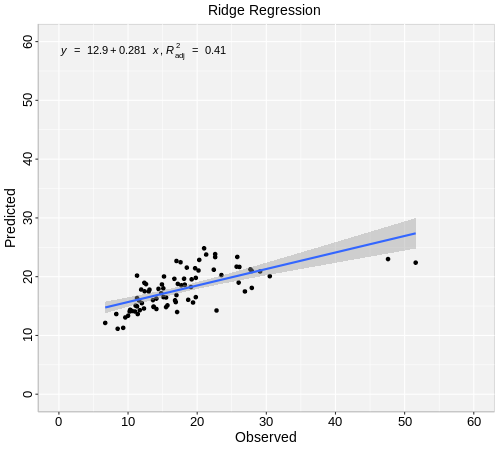

In [ ]:
%%R -w 500 -h 450 -u px
formula<-y~x
# Lasso regression
p1=ggplot(ridge.pred, aes(Obs_SAs,Pred_SAs)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("Ridge Regression ") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,60), breaks=seq(0, 60, 10))+
  scale_y_continuous(limits=c(0,60), breaks=seq(0, 60, 10)) +
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))
print(p1)

### LASSO regression

#### Cross Validation of the best Lasso regression

We can set up our model very similarly to our ridge function. We simply need to change the `alpha` argument to 1 and do K-fold cross-validation:

In [ ]:
%%R
# cross validation
lasso.cv <- cv.glmnet(x= x.train,
                       y= y.train,
                       type.measure="mse",
                       nfold = 5,
                       alpha=1,
                       family="gaussian",
                       nlambda=200,
                       standardize = TRUE)

In [ ]:
%%R
print(lasso.cv)


Call:  cv.glmnet(x = x.train, y = y.train, type.measure = "mse", nfolds = 5,      alpha = 1, family = "gaussian", nlambda = 200, standardize = TRUE) 

Measure: Mean-Squared Error 

    Lambda Index Measure    SE Nonzero
min 0.2343    62   27.91 2.482      11
1se 0.7452    37   30.25 2.741       9


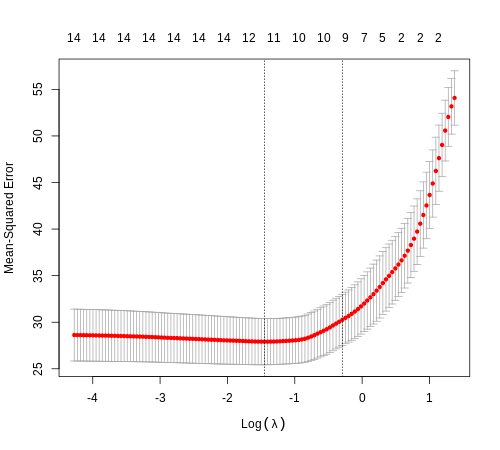

In [ ]:
%%R -w 500 -h 450 -u px
plot(lasso.cv)

In [ ]:
%%R
# Choose lambda with standard error of the minimum
lasso.cv$lambda.1se

[1] 0.7451964


#### Fit a lasso regression

Now Fit the final model with the best "lambda":

In [ ]:
%%R
# fit lasso regression
lasso.fit <-  glmnet(x= x.train,
                       y= y.train,
                       alpha=1,
                       lambda = lasso.cv$lambda.1se,
                       family="gaussian",
                       nlambda=200,
                       standardize = TRUE)


In [ ]:
%%R
print(lasso.fit)


Call:  glmnet(x = x.train, y = y.train, family = "gaussian", alpha = 1,      nlambda = 200, lambda = lasso.cv$lambda.1se, standardize = TRUE) 

  Df  %Dev Lambda
1  9 49.65 0.7452


Finally we will extract the coefficients for the selected $λ$ using `coef()` function:

In [ ]:
%%R
coef(lasso.fit)

15 x 1 sparse Matrix of class "dgCMatrix"
                         s0
(Intercept)     13.13129121
WAs              6.43205983
WP               .         
WFe              0.31947153
WEc              .         
WpH              .         
SAoFe            .         
SpH              .         
SOC              0.48232833
SP               0.01443477
Elevation       -0.10987428
Year_Irrigation  0.64081854
Distance_STW    -0.02963625
Silt_Sand       -0.07096227
Land_typeMHL     3.24183879



#### Prediction at Test Data

Now, we will test this model on our test dataset by calculating the model-predicted values for the test dataset and then computing the RMSE and R-square:

In [ ]:
%%R
# Make predictions on the test data
x.test <- model.matrix(SAs ~., test)[,-1]
y.test <-test$SAs

lasso.SAs<-lasso.fit  |>
  predict(x.test)  |>  as.vector()
lasso.pred<-as.data.frame(cbind("Obs_SAs" = y.test, "Pred_SAs"=lasso.SAs))
glimpse(lasso.pred)

Rows: 80
Columns: 2
$ Obs_SAs  <dbl> 11.30, 17.10, 11.70, 13.60, 19.80, 14.80, 15.10, 17.20, 10.00…
$ Pred_SAs <dbl> 14.81875, 12.92237, 13.27538, 14.81378, 16.53555, 13.81663, 1…


In [ ]:
%%R
# Model performance metrics
calculate_metrics(lasso.pred$Obs_SAs, lasso.pred$Pred_SAs)

$RMSE
[1] 5.774528

$MAE
[1] 3.989926

$MSE
[1] 33.34517

$MedAE
[1] 3.178921

$R2
[1] 0.4101343



#### 1:1 Plot of Predicted vs Observed values

We can plot observed and predicted values with fitted regression line with ggplot2

`geom_smooth()` using formula = 'y ~ x'


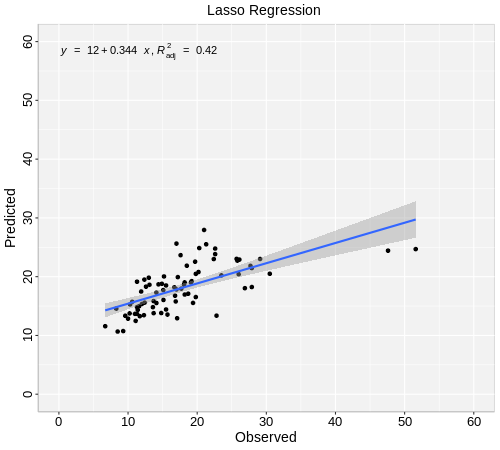

In [ ]:
%%R -w 500 -h 450 -u px
formula<-y~x
# Lasso regression
p2=ggplot(lasso.pred, aes(Obs_SAs,Pred_SAs)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("Lasso Regression ") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,60), breaks=seq(0, 60, 10))+
  scale_y_continuous(limits=c(0,60), breaks=seq(0, 60, 10)) +
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))
print(p2)

### Elastic Net Regression

Elastic Net regression is a combination of L1 (LASSO) and L2 (Ridge) regularization. It provides a balance between feature selection and coefficient shrinkage. The `glmnet` package in R provides efficient functions for fitting Elastic Net regression models.


#### Cross Validation of the best Elastic Net regression

We can set up our model very similarly to our ridge function. We simply need to change the `alpha`argument to a value between 0 and 1 and do K-fold cross-validation:

In [ ]:
%%R
# Define alpha values for Lasso, Ridge, and Elastic Net
alpha_values <- seq(0, 1, by = 0.1)

# Lambda will be generated automatically, but you can also define it manually:
lambda_values <- 10^seq(-4, 1, length.out = 100) # Logarithmic scale

# Cross-validation
results <- list()
for (alpha in alpha_values) {
  cv_model <- cv.glmnet(
    x = x.train,
    y = y.train,
    alpha = alpha,
    lambda = lambda_values,
    nfolds = 5, # 5-fold cross-validation
    standardize = TRUE # Standardizes the predictors by default
  )

  # Store results
  results[[paste("alpha=", alpha)]] <- list(
    alpha = alpha,
    best_lambda = cv_model$lambda.min,
    cv_model = cv_model
  )
}

best_result <- NULL
min_mse <- Inf

for (res in results) {
  mse <- min(res$cv_model$cvm) # Mean squared error
  if (mse < min_mse) {
    min_mse <- mse
    best_result <- res
  }
}

# Best model
cat("Best alpha:", best_result$alpha, "\n")
cat("Best lambda:", best_result$best_lambda, "\n")

Best alpha: 0.4 
Best lambda: 0.4862602 


#### Fit Elastic Net regression

In [ ]:
%%R
enet.fit  <- glmnet(
  x = x.train,
  y = y.train,
  alpha = best_result$alpha,
  lambda = best_result$best_lambda,
  standardize = TRUE
)

#### Prediction at Test Data

Now, we will test this model on our test dataset by calculating the model-predicted values for the test dataset

In [ ]:
%%R
# Make predictions on the test data
x.test <- model.matrix(SAs ~., test)[,-1]
y.test <-test$SAs

enet.SAs<-enet.fit  |>
  predict(x.test)  |>  as.vector()
enet.pred<-as.data.frame(cbind("Obs_SAs" = y.test, "Pred_SAs"=ridge.SAs))
glimpse(enet.pred)

Rows: 80
Columns: 2
$ Obs_SAs  <dbl> 11.30, 17.10, 11.70, 13.60, 19.80, 14.80, 15.10, 17.20, 10.00…
$ Pred_SAs <dbl> 16.35673, 13.98615, 14.29528, 16.00968, 16.51516, 17.19274, 1…


In [ ]:
%%R
# Model performance metrics
calculate_metrics(enet.pred$Obs_SAs, enet.pred$Pred_SAs)

$RMSE
[1] 5.953786

$MAE
[1] 4.018209

$MSE
[1] 35.44757

$MedAE
[1] 3.172252

$R2
[1] 0.3729436



#### 1:1 Plot of Predicted vs Observed values

We can plot observed and predicted values with fitted regression line with ggplot2

`geom_smooth()` using formula = 'y ~ x'


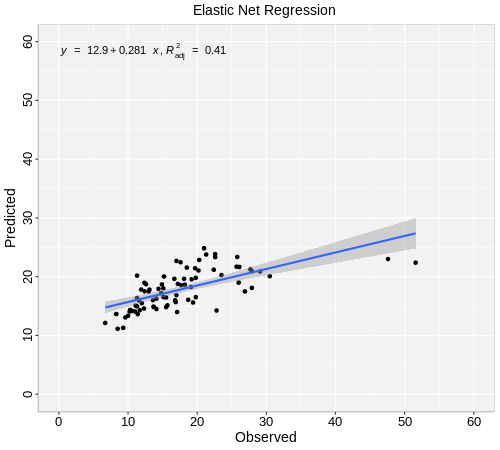

In [ ]:
%%R -w 500 -h 450 -u px
formula<-y~x
# Lasso regression
p3=ggplot(enet.pred, aes(Obs_SAs,Pred_SAs)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("Elastic Net Regression ") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,60), breaks=seq(0, 60, 10))+
  scale_y_continuous(limits=c(0,60), breaks=seq(0, 60, 10)) +
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))
print(p3)

## Summary and Conclusions

Regularized linear regression (GLM with a Gaussian distribution) helps prevent overfitting by shrinking the coefficient estimates, which can lead to simpler, more interpretable models. The choice of regularization method (L1, L2, or Elastic Net) depends on whether you need feature selection (L1), smoothness (L2), or a balance of both (Elastic Net). Although these methods may seem similar, they have significant differences. Ridge regression uses the square of the coefficients as a penalty, while Lasso regression uses the absolute value of the coefficients. Elastic Net regression combines the penalties of both Ridge and Lasso regression.

This tutorial explored how to implement Regularized Linear Models (GLMs) in R using {glmnet}. Regularized GLMs, such as LASSO, Ridge, and Elastic Net, are essential techniques in predictive modeling, especially when dealing with high-dimensional data or collinear predictors.

To summarize, each package has advantages and capabilities for implementing regularized GLMs in R. factors such as the dataset size, desired modeling workflow, and personal preference should be considered when choosing a package. By mastering these packages, researchers and data scientists can effectively use regularized GLMs for predictive modeling tasks, extracting valuable insights from complex datasets while mitigating overfitting and improving generalization performance.


## References

1.  [Lasso and Elastic-Net Regularized Generalized Linear Models](https://glmnet.stanford.edu/index.html)

2.  [Ridge, Lasso, and Elastic Net Regression using glmnet](https://rpubs.com/jmkelly91/881590)

3.  [Linear Model Selection and Regularization](https://emilhvitfeldt.github.io/ISLR-tidymodels-labs/06-regularization.html)
